<a href="https://colab.research.google.com/github/shuvayan/Plant-disease-detection-using-CNN/blob/main/LeafGuard_CNN_Iteration_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# import data handling tools
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from keras.applications import EfficientNetB7,MobileNetV2

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [7]:
!nvidia-smi

Tue Dec  3 08:49:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   49C    P8              17W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the PlantVillage dataset
dataset, dataset_info = tfds.load(
    'plant_village',
    as_supervised=True,  # Load the dataset as (image, label) pairs
    with_info=True,
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]']  # Train, Validation, Test splits
)

train_data, validation_data, test_data = dataset
num_classes = dataset_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

# On aws store the data on S3 bucket and pull from there.

Number of classes: 38


In [7]:
!pip install tensorflow-io


In [10]:
import tensorflow_io as tfio
import tensorflow as tf

def preprocess_image_tf(image, label):
    # Resize and normalize the image
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    # Convert to Lab color space using tfio
    lab_image = tfio.experimental.color.rgb_to_lab(image)
    l_channel, a_channel, b_channel = tf.split(lab_image, 3, axis=-1)

    # Apply any additional preprocessing, such as CLAHE-like transformation
    l_channel = clahe_like(l_channel)

    # Combine the preprocessed Lab channels
    processed_image = tf.concat([l_channel, a_channel, b_channel], axis=-1)

    return processed_image, label

def rgb_to_lab(image):
    """Convert RGB image to Lab color space."""
    # Assuming `image` is in [0, 1], convert to [0, 255] range
    image = image * 255.0
    image = tf.cast(image, tf.uint8)

    # Use TensorFlow IO function for color conversion
    lab_image = tfio.experimental.color.rgb_to_lab(image)
    return lab_image

def lab_to_rgb(lab_image):
    """Convert Lab color space back to RGB."""
    # Convert Lab to RGB using TensorFlow IO functions
    rgb_image = tfio.experimental.color.lab_to_rgb(lab_image)
    # Ensure the image is in the [0, 1] range
    return tf.clip_by_value(rgb_image, 0.0, 1.0)

def clahe_like(l_channel):
    """Simulate CLAHE effect on L channel using TensorFlow operations."""
    l_channel = tf.image.adjust_contrast(l_channel, contrast_factor=2.0)
    return l_channel


In [11]:
# Apply preprocessing to each dataset
train_data = train_data.map(preprocess_image_tf).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.map(preprocess_image_tf).batch(128).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_image_tf).batch(128).prefetch(tf.data.AUTOTUNE)

In [12]:
# Check if more advanced methods can be used here:
# Ideally we would like to have a second layer of Neural Network which learns the optimum weightages - based on classification F1-Score.

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
# Extract labels from the training dataset
train_labels = []
for _, label in train_data.unbatch():
    train_labels.append(label.numpy())

train_labels = np.array(train_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 2.2818573379556675, 1: 2.4479882790487997, 2: 5.172898309121219, 3: 0.8753526235189812, 4: 0.9448020878642889, 5: 1.734765593802412, 6: 1.343373121405158, 7: 2.8227420402859, 8: 1.1995913182747004, 9: 1.2174765988453562, 10: 1.4507747795885653, 11: 1.1958269103721648, 12: 1.0289923729215027, 13: 3.275674860503695, 14: 1.2976282932074796, 15: 0.25987963771670597, 16: 0.6219861405417788, 17: 3.915104542177361, 18: 1.429013157894737, 19: 0.9746040292547224, 20: 1.4434476342371079, 21: 9.370578084555651, 22: 1.4272291214928707, 23: 3.7854653189264553, 24: 0.2827629300805811, 25: 0.7798161843900338, 26: 3.238556731772775, 27: 1.2385812852825455, 28: 0.6600522669259754, 29: 1.4166177525598382, 30: 0.9065904253099044, 31: 0.7447625578604492, 32: 1.5081933064852104, 33: 0.8113630420977924, 34: 0.8405959752321981, 35: 1.0170912155834426, 36: 3.7729720340455097, 37: 0.268864187750656}


In [13]:
def create_cnn_with_mobilenetv2(num_classes):
    # Load MobileNetV2 as the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of MobileNetV2
    base_model.trainable = False

    # Add custom layers on top of MobileNetV2
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Replace Flatten with GlobalAveragePooling2D for better performance
        Dropout(0.4),
        Dense(1024, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    return model

In [1]:
# defining path names for futur use
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Augmented_PlantVillage'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import tensorflow as tf
from keras.applications import MobileNetV2, EfficientNetV2B0, ConvNeXtLarge
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
# Enable autologging for TensorFlow
mlflow.tensorflow.autolog()

def create_cnn_with_mobilenetv2(K):
    # Load MobileNetV2 as the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model layers

    # Add custom layers on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.4),
        Dense(1024, activation='relu'),
        Dropout(0.4),
        Dense(K, activation='softmax')  # K is the number of classes
    ])

    return model

# Define hyperparameters
K = 38
learning_rate = 0.001
batch_size = 128
epochs = 67


# Start MLflow experiment
mlflow.set_experiment("PlantVillage_Classification_mobnet")

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

    # Create and compile model
    model = create_cnn_with_mobilenetv2(K)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=67,
        steps_per_epoch=350,
        validation_steps=350,
        class_weight=class_weights  # Optional: Use class weights if dataset is imbalanced
    )

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(validation_data)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Save the model
    model.save("/content/drive/My Drive/Augmented_PlantVillage/plant_village_model_mobnet.keras")

    mlflow.tensorflow.log_model(model,
                                 artifact_path="keras_model")


Epoch 1/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 138s 360ms/step - accuracy: 0.4145 - loss: 2.1333 - val_accuracy: 0.7656 - val_loss: 0.7899
Epoch 2/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 127s 354ms/step - accuracy: 0.6490 - loss: 1.0948 - val_accuracy: 0.7853 - val_loss: 0.7059
Epoch 3/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 353ms/step - accuracy: 0.6943 - loss: 0.9439 - val_accuracy: 0.7929 - val_loss: 0.6660
Epoch 4/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 352ms/step - accuracy: 0.7129 - loss: 0.8724 - val_accuracy: 0.7713 - val_loss: 0.6821
Epoch 5/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 127s 354ms/step - accuracy: 0.7287 - loss: 0.8181 - val_accuracy: 0.8091 - val_loss: 0.5879
Epoch 6/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 352ms/step - accuracy: 0.7372 - loss: 0.7933 - val_accuracy: 0.8179 - val_loss: 0.5669
Epoch 7/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 352ms/step - accuracy: 0.7468 - loss: 0.7507 - val_accuracy: 0.8127 - val_loss: 0.5918
Epoch 8/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 352ms/step - accuracy: 0.7515 -

2024/12/03 13:50:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='128' for run ID='1804a76a52f649618dbb8139e5288d85'. Attempted logging new value 'None'.


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 315ms/step - accuracy: 0.8541 - loss: 0.4631


2024/12/03 13:50:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/12/03 13:51:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [19]:
!pip install pyngrok

In [20]:
get_ipython().system_raw("mlflow ui --port 5000 &")

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2peXUVBdrKVSkftiKrqd0rJ7MPa_7AN3ERERCuV5t3LaU54tK"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://ea0b-34-143-209-15.ngrok-free.app


In [ ]:
def create_cnn_with_efficient_netv2(num_classes):
    # Load MobileNetV2 as the base model
    base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of MobileNetV2
    base_model.trainable = False

    # Add custom layers on top of MobileNetV2
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Replace Flatten with GlobalAveragePooling2D for better performance
        Dropout(0.4),
        Dense(1024, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    return model


# Create and compile the model
model = create_cnn_with_efficient_netv2(num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
# Train the model
#history = model.fit(
#    train_data,
#    validation_data=validation_data,
#    epochs=10,
#    steps_per_epoch=150,
#    validation_steps=150,
#    class_weight=class_weights  # Optional: Use class weights if dataset is imbalanced
#)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.3057 - loss: 2.6666 - val_accuracy: 0.6376 - val_loss: 1.1620
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.5655 - loss: 1.4058 - val_accuracy: 0.7558 - val_loss: 0.8410
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 805ms/step - accuracy: 0.6066 - loss: 1.2202 - val_accuracy: 0.7284 - val_loss: 0.8812
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.6454 - loss: 1.1054 - val_accuracy: 0.7244 - val_loss: 0.8461
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.6530 - loss: 1.0514 - val_accuracy: 0.7415 - val_loss: 0.8024
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 849ms/step - accuracy: 0.6830 - loss: 0.9907 - val_accuracy: 0.7831 - val_loss: 0.7082
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.6950 - loss: 0.9463 - val_accuracy: 0.7739 - val_loss: 0.7205
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - accuracy: 0.6844 - loss: 0.9573 - va

In [ ]:
!nvidia-smi

Mon Dec  2 05:47:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   66C    P0              31W /  72W |    223MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install MLflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [4]:
import mlflow
import mlflow.tensorflow


In [ ]:
# defining path names for futur use
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Augmented_PlantVillage'


In [ ]:

# Enable autologging for TensorFlow
mlflow.tensorflow.autolog()

def create_cnn_with_mobilenetv2(K):
    # Load MobileNetV2 as the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model layers

    # Add custom layers on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.4),
        Dense(1024, activation='relu'),
        Dropout(0.4),
        Dense(K, activation='softmax')  # K is the number of classes
    ])

    return model

# Define hyperparameters
K = 38
learning_rate = 0.001
batch_size = 128
epochs = 67


# Start MLflow experiment
mlflow.set_experiment("PlantVillage_Classification")

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

    # Create and compile model
    model = create_cnn_with_mobilenetv2(K)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=67,
        steps_per_epoch=350,
        validation_steps=350,
        class_weight=class_weights  # Optional: Use class weights if dataset is imbalanced
    )

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(validation_data)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Save the model
    model.save("/content/drive/My Drive/Augmented_PlantVillage/plant_village_model.keras")

    mlflow.tensorflow.log_model(tf_saved_model_dir=model_path,
                                 artifact_path="keras_model")


Epoch 1/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 138s 358ms/step - accuracy: 0.4024 - loss: 2.1788 - val_accuracy: 0.7120 - val_loss: 0.9437
Epoch 2/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 350ms/step - accuracy: 0.6535 - loss: 1.0887 - val_accuracy: 0.7750 - val_loss: 0.7176
Epoch 3/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 350ms/step - accuracy: 0.6892 - loss: 0.9589 - val_accuracy: 0.7846 - val_loss: 0.6738
Epoch 4/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 350ms/step - accuracy: 0.7109 - loss: 0.8835 - val_accuracy: 0.8155 - val_loss: 0.5940
Epoch 5/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 351ms/step - accuracy: 0.7253 - loss: 0.8321 - val_accuracy: 0.8103 - val_loss: 0.5968
Epoch 6/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 350ms/step - accuracy: 0.7309 - loss: 0.7933 - val_accuracy: 0.8109 - val_loss: 0.5893
Epoch 7/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 350ms/step - accuracy: 0.7413 - loss: 0.7621 - val_accuracy: 0.8144 - val_loss: 0.5532
Epoch 8/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 125s 350ms/step - accuracy: 0.7532 -

2024/12/02 10:44:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='128' for run ID='f36a39f2f6bc4e968d8899293cc9af4f'. Attempted logging new value 'None'.


 8/43 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.8665 - loss: 0.4399

In [ ]:
#mlflow.set_tracking_uri("s3://your-bucket-name/mlflow")
history

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

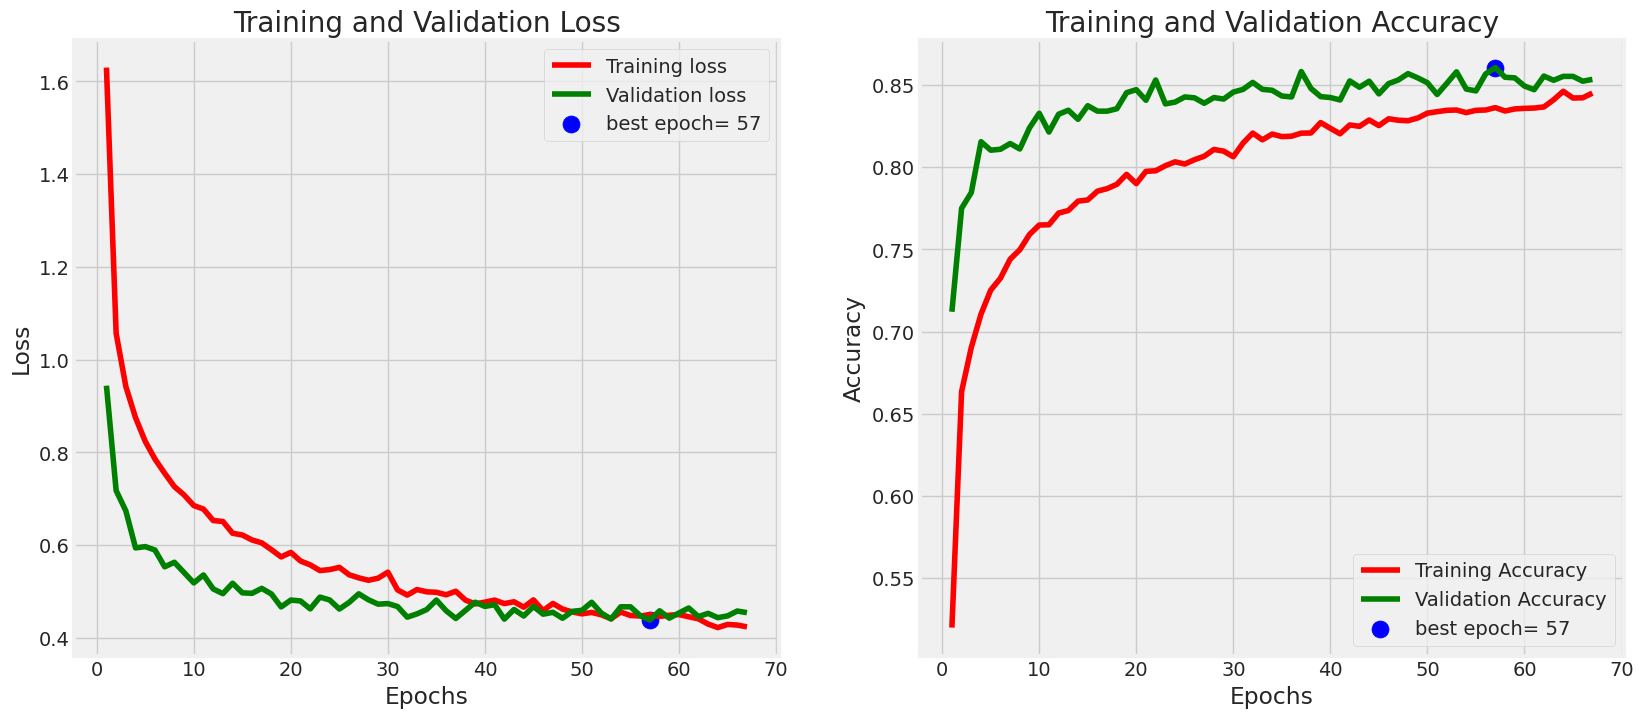

In [ ]:
plot_training(history)

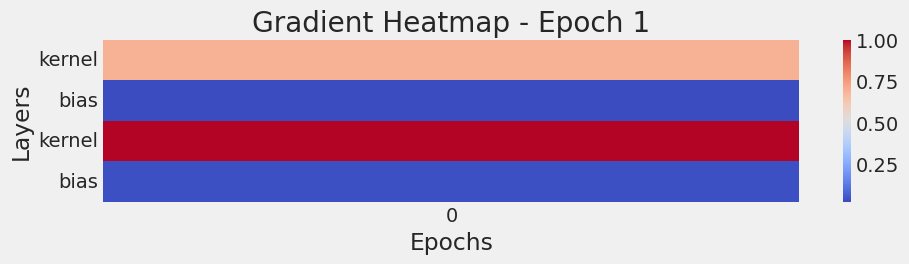

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to create heatmap
def plot_gradient_heatmap(gradients, layer_names, epoch):
    gradient_matrix = np.array(gradients)
    plt.figure(figsize=(10, len(layer_names) * 0.5))
    sns.heatmap(
        gradient_matrix,
        annot=False,
        cmap='coolwarm',
        cbar=True,
        yticklabels=layer_names
    )
    plt.title(f"Gradient Heatmap - Epoch {epoch}")
    plt.xlabel("Epochs")
    plt.ylabel("Layers")
    plt.show()

# Store gradients over epochs
gradient_history = []
layer_names = [layer.name for layer in model.trainable_weights]

for epoch in range(epochs):
    epoch_gradients = []
    for step, (images, labels) in enumerate(train_data):
        # Track gradients only every 10 steps
        if step % 10 != 0:
            continue

        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_weights)
        # Compute L2 norm of gradients for each layer
        layer_gradients = [
            tf.norm(g).numpy() if g is not None else 0 for g in gradients
        ]
        epoch_gradients.append(layer_gradients)

    # Average gradients across all tracked steps for the epoch
    avg_gradients = np.mean(epoch_gradients, axis=0)

    # Normalize gradients for visualization
    norm_gradients = avg_gradients / (np.max(avg_gradients) + 1e-8)  # Avoid division by zero
    gradient_history.append(norm_gradients)

    # Plot heatmap for the current epoch
    plot_gradient_heatmap(np.array(gradient_history).T, layer_names, epoch + 1)


In [ ]:
val_predictions = model.predict(train_data)

340/340 ━━━━━━━━━━━━━━━━━━━━ 114s 329ms/step


In [ ]:
get_ipython().system_raw("mlflow ui --port 5000 &")

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2peXUVBdrKVSkftiKrqd0rJ7MPa_7AN3ERERCuV5t3LaU54tK"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [ ]:

# Enable autologging for TensorFlow
mlflow.tensorflow.autolog()

def create_cnn_with_mobilenetv2(K):
    # Load EfficientNetB7 as the base model
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model layers

    # Add custom layers on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.4),
        Dense(1024, activation='relu'),
        Dropout(0.4),
        Dense(K, activation='softmax')  # K is the number of classes
    ])

    return model

# Define hyperparameters
K = 38
learning_rate = 0.001
batch_size = 128
epochs = 67


# Start MLflow experiment
mlflow.set_experiment("PlantVillage_Classification_V2")

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

    # Create TensorBoard log directory within the MLflow artifact directory
    tensorboard_log_dir = os.path.join(mlflow.get_artifact_uri(), "tensorboard_logs")

    # Set up TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)


    # Create and compile model
    model = create_cnn_with_mobilenetv2(K)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=67,
        steps_per_epoch=350,
        validation_steps=350,
        class_weight=class_weights  # Optional: Use class weights if dataset is imbalanced
    )

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(validation_data)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Save the model
    model.save("/content/drive/My Drive/Augmented_PlantVillage/plant_village_model_ef.keras")

    mlflow.tensorflow.log_model(model_path,
                                 artifact_path="keras_model")


Epoch 1/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 364s 842ms/step - accuracy: 0.5668 - loss: 1.5051 - val_accuracy: 0.8378 - val_loss: 0.5069
Epoch 2/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 239s 675ms/step - accuracy: 0.8014 - loss: 0.6002 - val_accuracy: 0.8720 - val_loss: 0.3872
Epoch 3/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 239s 674ms/step - accuracy: 0.8250 - loss: 0.5134 - val_accuracy: 0.8912 - val_loss: 0.3281
Epoch 4/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 238s 673ms/step - accuracy: 0.8415 - loss: 0.4553 - val_accuracy: 0.8962 - val_loss: 0.3239
Epoch 5/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 239s 674ms/step - accuracy: 0.8466 - loss: 0.4298 - val_accuracy: 0.9046 - val_loss: 0.2844
Epoch 6/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 238s 673ms/step - accuracy: 0.8562 - loss: 0.4153 - val_accuracy: 0.9024 - val_loss: 0.2858
Epoch 7/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 239s 675ms/step - accuracy: 0.8605 - loss: 0.3937 - val_accuracy: 0.9087 - val_loss: 0.2625
Epoch 8/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 238s 673ms/step - accuracy: 0.8701 -

In [1]:
get_ipython().system_raw("mlflow ui --port 5000 &")

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2peXUVBdrKVSkftiKrqd0rJ7MPa_7AN3ERERCuV5t3LaU54tK"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

ModuleNotFoundError: No module named 'pyngrok'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.applications import MobileNetV2,EfficientNetV2B1,ConvNeXtXLarge

In [ ]:
import os
from keras.callbacks import TensorBoard

%load_ext tensorboard
import datetime

log_dir = "//content/drive/My Drive/Augmented_PlantVillage/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Enable autologging for TensorFlow
mlflow.tensorflow.autolog()

def create_cnn_with_covnet(K):
    # Load EfficientNetB7 as the base model
    base_model = ConvNeXtXLarge(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model layers

    # Add custom layers on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.4),
        Dense(1024, activation='relu'),
        Dropout(0.4),
        Dense(K, activation='softmax')  # K is the number of classes
    ])

    return model

# Define hyperparameters
K = 38
learning_rate = 0.001
batch_size = 128
epochs = 67


# Start MLflow experiment
mlflow.set_experiment("PlantVillage_Classification_V3")

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

    # Create TensorBoard log directory within the MLflow artifact directory
    tensorboard_log_dir = os.path.join(mlflow.get_artifact_uri(), "tensorboard_logs")

    # Set up TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


    # Create and compile model
    model = create_cnn_with_covnet(K)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        steps_per_epoch=350,
        validation_steps=350,
        class_weight=class_weights,  # Optional: Use class weights if dataset is imbalanced
        callbacks=[tensorboard_callback]
    )

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(validation_data)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Save the model
    model.save("/content/drive/My Drive/Augmented_PlantVillage/plant_village_model_covnet.keras")

    mlflow.tensorflow.log_model(model_path,
                                 artifact_path="keras_model")

2024/12/02 15:43:54 INFO mlflow.tracking.fluent: Experiment with name 'PlantVillage_Classification_V3' does not exist. Creating a new experiment.


1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 637s 2s/step - accuracy: 0.7600 - loss: 0.8514 - val_accuracy: 0.9519 - val_loss: 0.1468
Epoch 2/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.9343 - loss: 0.2098 - val_accuracy: 0.9683 - val_loss: 0.0978
Epoch 3/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.9523 - loss: 0.1494 - val_accuracy: 0.9641 - val_loss: 0.0984
Epoch 4/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.9514 - loss: 0.1531 - val_accuracy: 0.9735 - val_loss: 0.0722
Epoch 5/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.9595 - loss: 0.1192 - val_accuracy: 0.9724 - val_loss: 0.0800
Epoch 6/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 544s 2s/step - accuracy: 0.9586 - loss: 0.1331 - val_accuracy: 0.9729 - val_loss: 0.0721
Epoch 7/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.9646 - loss: 0.1138 - val_accuracy: 0.9735 - val_loss: 0.0737
Epoch 8/67
350/350 ━━━━━━━━━━━━━━━━━━━━ 5

2024/12/03 01:52:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='128' for run ID='6e5026a0ec9d46dba2a87b05c7a92a50'. Attempted logging new value 'None'.


43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9833 - loss: 0.0756


TypeError: log_model() got an unexpected keyword argument 'tf_saved_model_dir'

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

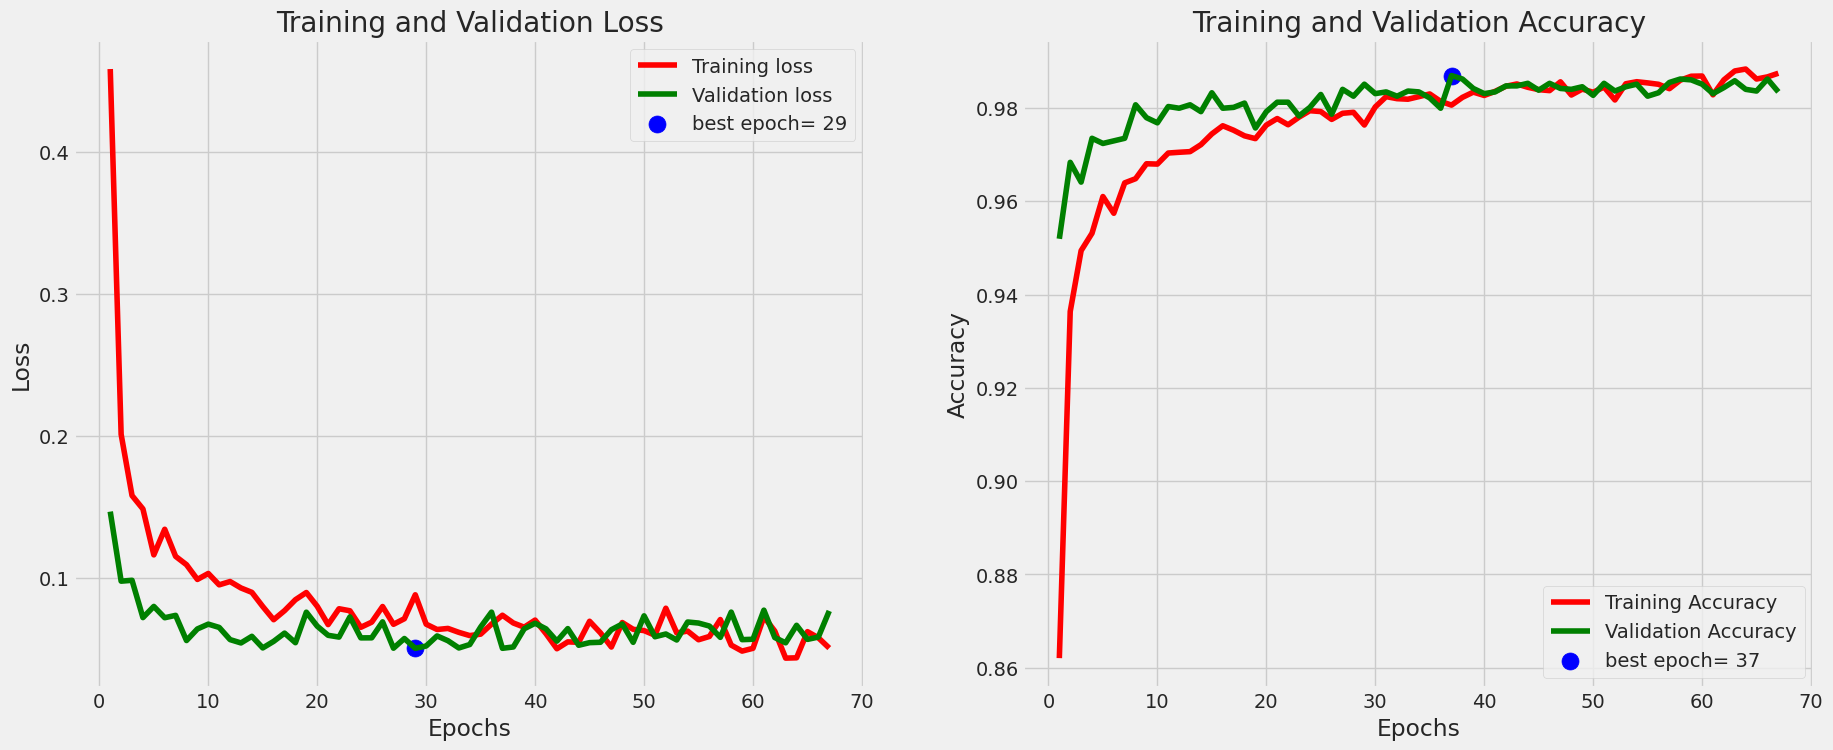

In [ ]:
plot_training(history)

In [4]:
%load_ext tensorboard

log_dir = "/content/drive/My Drive/Augmented_PlantVillage/logs/fit/20241202-154354_CovNet/train"
%tensorboard --log_dir log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-12-03 06:28:53.703982: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 06:28:53.721591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 06:28:53.742285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 06:28:53.748595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registere

In [19]:
# Stop the profiler after training
tf.profiler.experimental.stop()


In [18]:
import tensorflow as tf
import os

# Define the SQLite database path
sqlite_db_path = "/content/drive/My Drive/Augmented_PlantVillage/logs/fit/tensorboard_logs.db"

# Start TensorFlow Profiler with SQLite logging
tf.profiler.experimental.start(
    logdir=sqlite_db_path
    #,profiler_options=tf.profiler.experimental.ProfilerOptions(host_tracer_level=2)
)

# Define your model and train as usual
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_data, validation_data=validation_data, epochs=5)
tf.profiler.experimental.stop()


AlreadyExistsError: Another profiler is running.

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, BatchNormalization, Input

def create_custom_cnn(input_shape=(256, 256, 3), num_classes=38):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Global Pooling and Dense Layers
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [14]:
model = create_custom_cnn(input_shape=(256, 256, 3), num_classes=38)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,327,174 (5.06 MB)

 Trainable params: 1,325,254 (5.06 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [1]:
tf.profiler.experimental.stop()

NameError: name 'tf' is not defined

In [ ]:
import tensorflow as tf
import os

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)



# Define the SQLite database path
sqlite_db_path = "/content/drive/My Drive/Augmented_PlantVillage/logs/fit/tensorboard_logs.db"

# Start TensorFlow Profiler with SQLite logging
tf.profiler.experimental.start(
    logdir=sqlite_db_path
    ,options=tf.profiler.experimental.ProfilerOptions(host_tracer_level=2)
)


history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr]
)
tf.profiler.experimental.stop()


Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 319s 720ms/step - accuracy: 0.5851 - loss: 1.7950 - val_accuracy: 0.7450 - val_loss: 1.1012 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 184s 532ms/step - accuracy: 0.8537 - loss: 0.6969 - val_accuracy: 0.8017 - val_loss: 0.8463 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 184s 532ms/step - accuracy: 0.9068 - loss: 0.4498 - val_accuracy: 0.9144 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 4/100
267/340 ━━━━━━━━━━━━━━━━━━━━ 42s 578ms/step - accuracy: 0.9339 - loss: 0.3221